In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1_path = "./000006-color.jpg"
img2_path = "./000007-color.jpg"
img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)
img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detect SIFT features
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

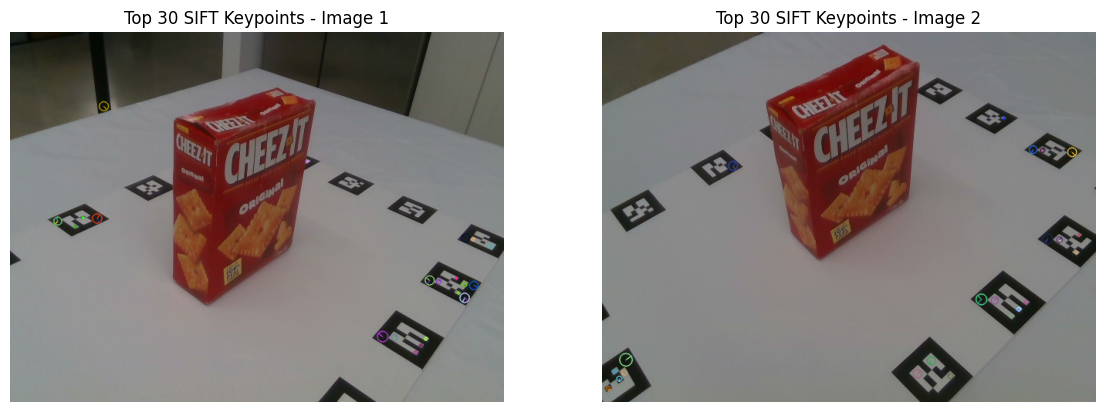

In [5]:
# Draw top 30 strongest features
img1_kp = cv2.drawKeypoints(img1, sorted(kp1, key=lambda x: -x.response)[:30], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, sorted(kp2, key=lambda x: -x.response)[:30], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Visualize 30 strongest keypoints
img1_kp = cv2.drawKeypoints(img1, sorted(kp1, key=lambda x: -x.response)[:30], None,
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, sorted(kp2, key=lambda x: -x.response)[:30], None,
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display keypoints
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
plt.title('Top 30 SIFT Keypoints - Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
plt.title('Top 30 SIFT Keypoints - Image 2')
plt.axis('off')
plt.show()

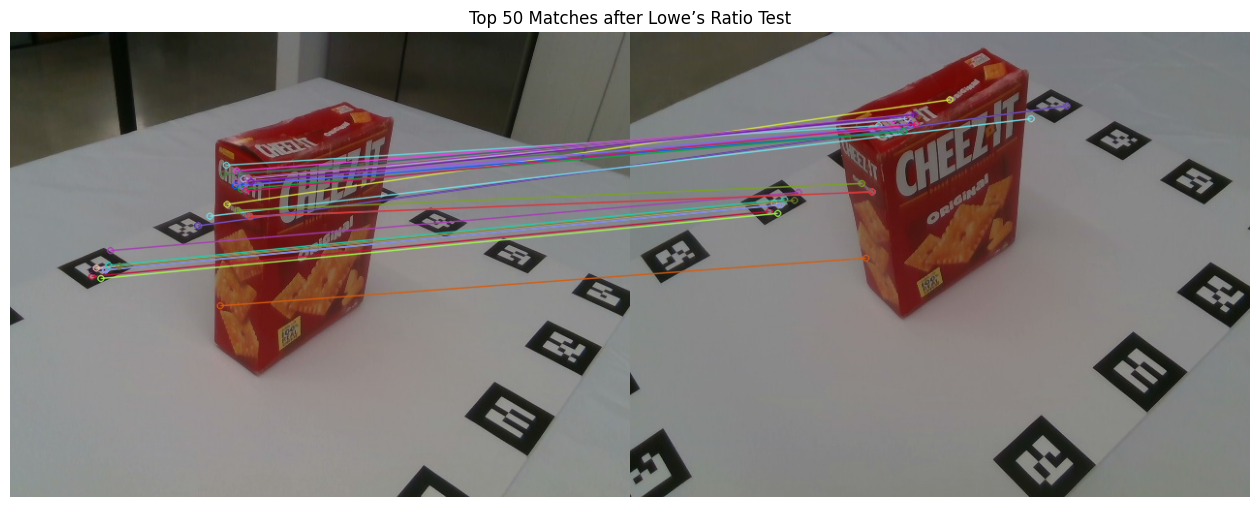

In [7]:
# Match features using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw first 50 matches
matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:30], None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show matches
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title('Top 50 Matches after Lowe’s Ratio Test')
plt.axis('off')
plt.show()

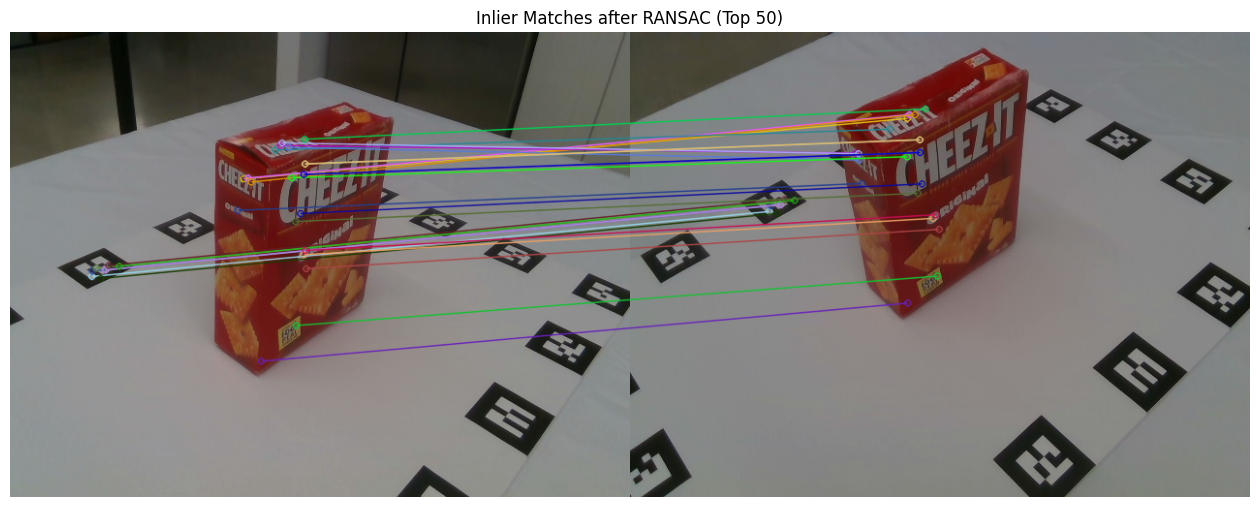

In [9]:
# Step 2: Extract matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Compute the fundamental matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select only inlier matches
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

# Visualize inlier matches
inlier_img = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches[:30], None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the result
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(inlier_img, cv2.COLOR_BGR2RGB))
plt.title('Inlier Matches after RANSAC (Top 50)')
plt.axis('off')
plt.show()

# For Step 3 and Step 4, we will use the filtered inlier points
pts1_inliers = np.float32([kp1[m.queryIdx].pt for m in inlier_matches])
pts2_inliers = np.float32([kp2[m.trainIdx].pt for m in inlier_matches])

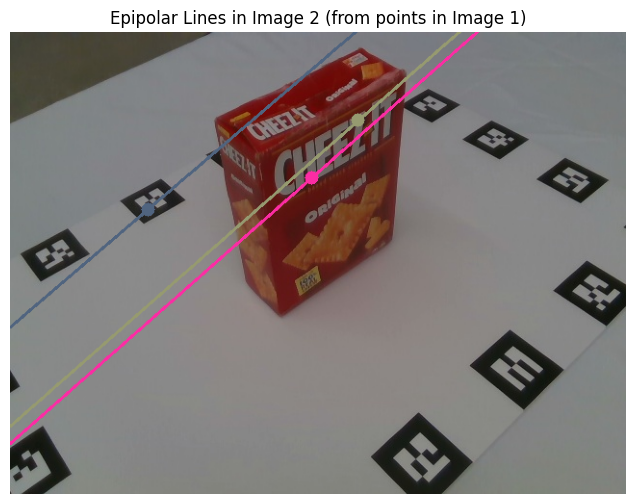

In [25]:
def draw_epipolar_lines(img, lines, pts):
    """Draw epipolar lines and corresponding points"""
    img_out = img.copy()
    h, w = img.shape[:2]
    for r, pt in zip(lines, pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [w, -(r[2] + r[0] * w) / r[1]])
        cv2.line(img_out, (x0, y0), (x1, y1), color, 2)
        cv2.circle(img_out, tuple(np.int32(pt)), 7, color, -1)
    return img_out

# Pick widely spaced sample inlier points
indices = [0, len(pts1_inliers)//3, 2*len(pts1_inliers)//3]
sample_pts1 = pts1_inliers[indices]
sample_pts1_hom = np.hstack([sample_pts1, np.ones((3, 1))])
epilines2 = (F @ sample_pts1_hom.T).T
img2_epilines = draw_epipolar_lines(img2, epilines2, pts2_inliers[indices])

# Show result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img2_epilines, cv2.COLOR_BGR2RGB))
plt.title("Epipolar Lines in Image 2 (from points in Image 1)")
plt.axis('off')
plt.show()

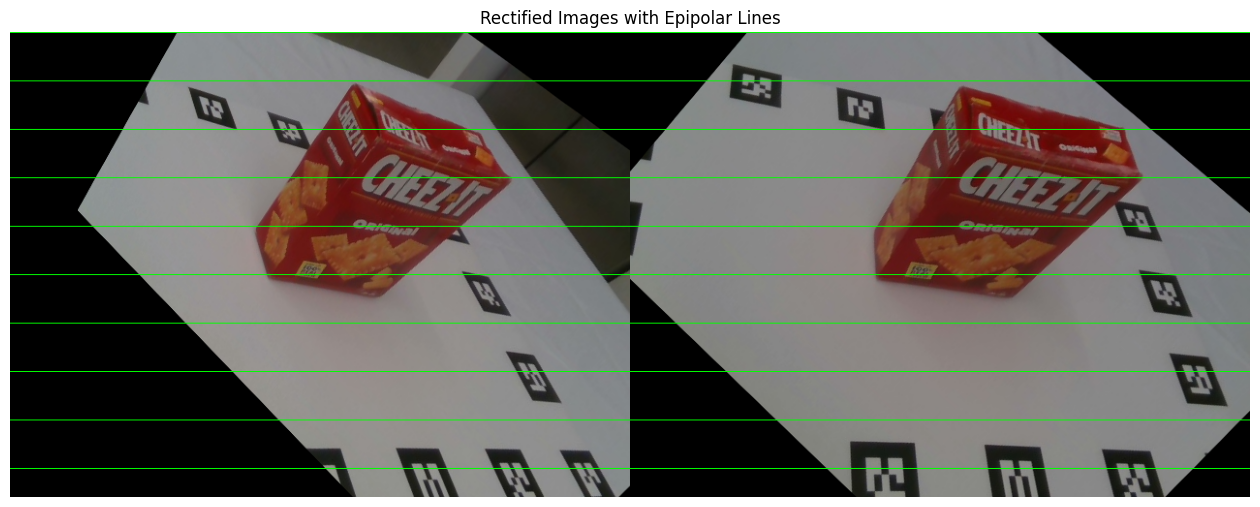

In [26]:
# Step 4.1: Compute Rectification Homographies
h1, w1 = img1.shape[:2]
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    pts1_inliers, pts2_inliers, F, imgSize=(w1, h1)
)

# Step 4.2: Apply the Homographies
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w1, h1))

# Display rectified images side-by-side with horizontal lines
def show_rectified(imgL, imgR):
    canvas = np.hstack((imgL, imgR))
    for y in range(0, canvas.shape[0], 50):
        cv2.line(canvas, (0, y), (canvas.shape[1], y), (0, 255, 0), 1)
    return canvas

# Show the rectified image pair
rectified_pair = show_rectified(img1_rectified, img2_rectified)
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(rectified_pair, cv2.COLOR_BGR2RGB))
plt.title("Rectified Images with Epipolar Lines")
plt.axis('off')
plt.show()

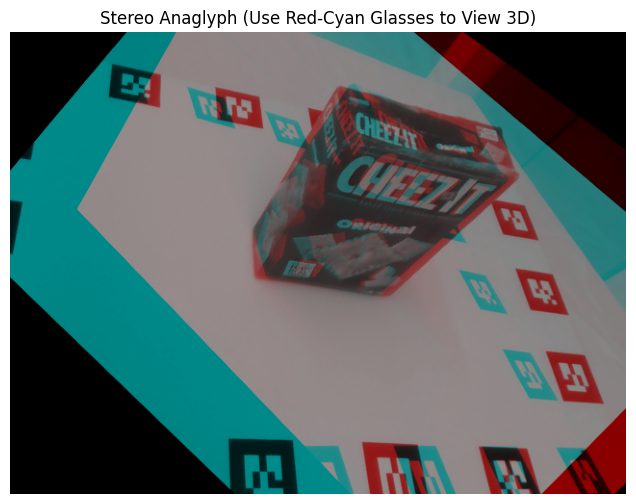

In [27]:
# Ensure images are grayscale or properly aligned in shape
grayL = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2GRAY)

# Create a stereo anaglyph (Red: Left, Green+Blue: Right)
anaglyph = np.zeros_like(img1_rectified)
anaglyph[..., 0] = grayR  # Blue
anaglyph[..., 1] = grayR  # Green
anaglyph[..., 2] = grayL  # Red

# Show stereo anaglyph
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(anaglyph, cv2.COLOR_BGR2RGB))
plt.title("Stereo Anaglyph (Use Red-Cyan Glasses to View 3D)")
plt.axis('off')
plt.show()